In [1]:
from fastai.vision.all import *

In [2]:
path = 'dataset'
fnames = get_image_files(path)
def label_func(x): return x.parent.name

In [3]:
dls = ImageDataLoaders.from_path_func(path, fnames, label_func, number_workers=0)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


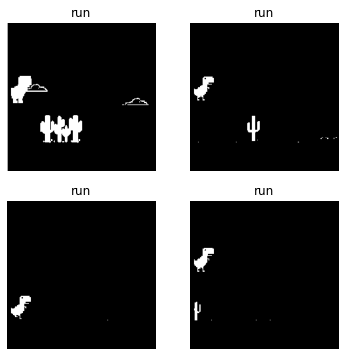

In [4]:
dls.valid.show_batch(max_n=4, nrows=2)

last image is caused by game background transition

In [5]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])

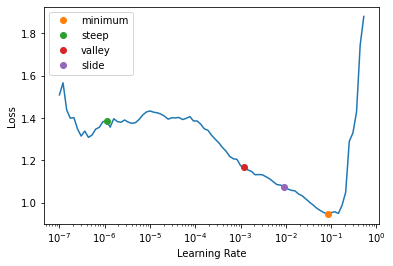

In [6]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [6]:
learn.fine_tune(8, base_lr=10e-03)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.510892,0.548278,0.194981,0.805019,01:58


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.262170,0.222416,0.055985,0.944015,02:32
1,0.195420,0.557111,0.115830,0.884170,02:33
2,0.182060,0.189753,0.059846,0.940154,02:32
3,0.153939,0.273719,0.079151,0.920849,02:33
4,0.127134,0.204846,0.048263,0.951737,02:32
5,0.091170,0.173398,0.042471,0.957529,02:32
6,0.064571,0.180738,0.042471,0.957529,02:32
7,0.044193,0.186306,0.038610,0.961390,02:31


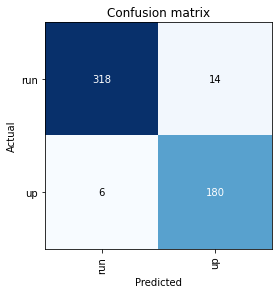

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [8]:
interp.print_classification_report()

              precision    recall  f1-score   support

         run       0.98      0.96      0.97       332
          up       0.93      0.97      0.95       186

    accuracy                           0.96       518
   macro avg       0.95      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



In [9]:
learn.export(os.path.abspath('models/v5.pkl'))